In [3]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import pyloudnorm as pyln
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
from scipy.signal import savgol_filter

from data.dataset import MultitrackAudioDataset
from data.dataset_utils import load_tracks, load_tracks_musdb18
from data.medleydb_split import weathervane_music
from models.model_scalar_v2 import MixingModelScalar2d
from inference_utils import mix_song_smooth
from evaluation import LoudnessEvaluator

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

Torch version:  1.6.0
Device:  cuda


In [5]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio'
seed = 321
chunk_length = 1

d = MultitrackAudioDataset(
    base_path,
    songlist=[],
    chunk_length=chunk_length,
    normalize=False,
    compute_features=False
)

In [6]:
model = MixingModelScalar2d().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

908400 trainable parameters


In [7]:
# weights = './saved_models/scalar2d_scalar2d_6669.pt'
weights = './saved_models/training-ignite-unnorm-70-epochs-135.08-val-loss-fter-bugfix/scalar2d_scalar2d_5658.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [12]:
# base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
# song_name = 'Creepoid_OldTree'
# loaded_tracks = load_tracks(base_dir, song_name)

base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MUSDB18HQ/test/'
song_name = 'Triviul feat. The Fiend - Widow'
loaded_tracks = load_tracks_musdb18(base_dir, song_name)

# evaluate_loudness(loaded_tracks)

---
### Mix MedleyDB

In [12]:
# random_gains = np.random.uniform(0.1, 2.5, size=4)
# print(random_gains)

# for i, track in enumerate(loaded_tracks):
#     if track != 'mix':
#         loaded_tracks[track] = random_gains[i] * loaded_tracks[track]

mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks)

loudness = evaluate_loudness(mixed_tracks)
print(loudness)

# mix = librosa.util.normalize(mixed_tracks['mix'], axis=1)
mix = mixed_tracks['mix']

sf.write('./results/{}_mixed.wav'.format(song_name), mix.T, 44100)

BASS loudness: -24.65077
DRUMS loudness: -18.54892
VOCALS loudness: -14.02394
OTHER loudness: -7.65084
MIX loudness: -7.06406
[3.4896059711009877, 2.625817240117557, 1.9852527779691636, 1.08306641995965, 1.0]


---
### Mix MUSDB18

In [13]:
# randomly fuck up gains before the inference
# random_gains = np.random.uniform(0.5, 2.0, size=4)
# print(random_gains)

# for i, track in enumerate(loaded_tracks):
#     if track != 'mix':
#         loaded_tracks[track] = random_gains[i] * loaded_tracks[track]

# loudness = evaluate_loudness(loaded_tracks)
# print(loudness)
# print('-' * 80)

mixed_tracks, raw_gains, smooth_gains = mix_song_smooth(d, model, loaded_tracks)

# loudness = evaluate_loudness(mixed_tracks)
# print(loudness)

mix = librosa.util.normalize(mixed_tracks['mix'], axis=1)
# mix = mixed_tracks['mix']

sf.write('./results/{}_mixed.wav'.format(song_name), mix.T, 44100)

In [14]:
# ---------------------------------------------------------------------
# producing a sum track for comparison
tracks = ['bass', 'drums', 'vocals', 'other']
coeffs = [1.0, 1.0, 1.0, 1.0]

sum_track = np.zeros_like(loaded_tracks['mix'])
for i, track in enumerate(tracks):
    sum_track += coeffs[i] * loaded_tracks[track]

sum_track = librosa.util.normalize(sum_track, axis=1)
sf.write('./results/{}_sum.wav'.format(song_name), sum_track.T, 44100)

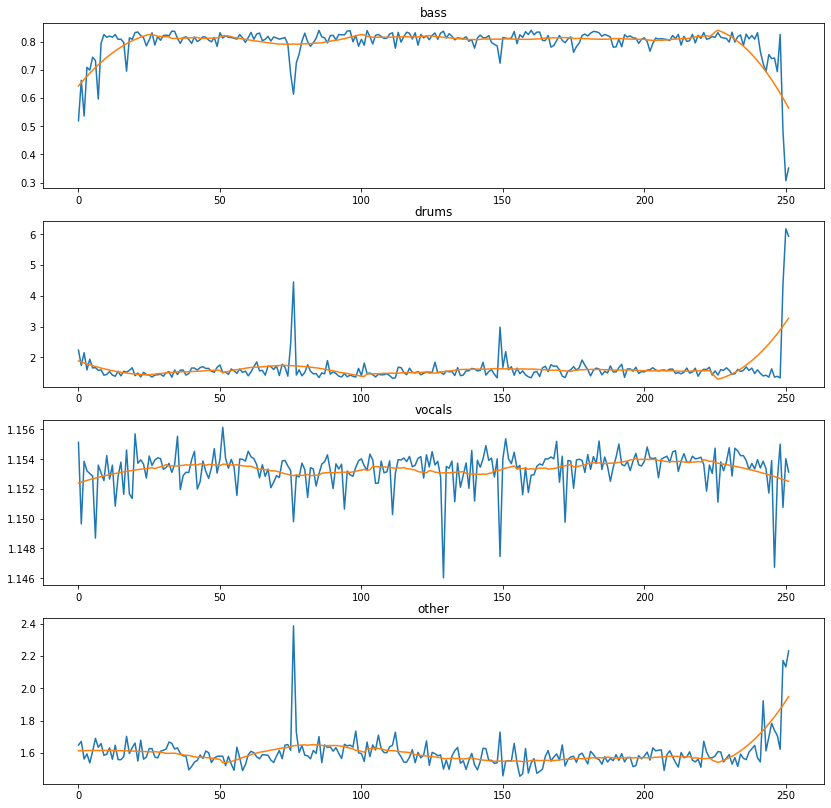

In [14]:
plt.figure(figsize=(14, 14))

for i, track in enumerate(raw_gains):
    plt.subplot(4, 1, i + 1)
    plt.title(track)

    x_vals = range(len(raw_gains['bass']))
    plt.plot(x_vals, raw_gains[track])
    plt.plot(x_vals, smooth_gains[track])